# The Generalization Model: From Raw Sensors to Causal Structures

## Research Objective
To scientifically "discover" the latent behavioral constructs (Nodes) for the **Average User** and their robust causal dependencies (Edges) from the high-dimensional GLOBEM dataset.

## Methodology
1.  **Domain-Guided Factor Analysis**: We partition raw sensors into semantic domains (Sleep, Social, Screen, Mobility) and extract orthogonal latent factors within each domain. This creates interpretable nodes like "Sleep Quality" or "Social Regularity".
2.  **Robust Structure Learning (Bootstrapping)**: We apply the **PC Algorithm** on multiple random resamples of the data to discover stable causal connections, filtering out noise.
3.  **Visualization**: We render the final **Generalized Domain DAG**, color-coded by behavioral domain.

---

In [44]:
# 1. Environment Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import networkx as nx
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

# Causal Discovery Libraries
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz

# Scientific Plotting Config
sns.set(style='whitegrid', context='paper', font_scale=1.4)
plt.rcParams['figure.figsize'] = (14, 8)
pd.set_option('display.max_columns', 50)

DATA_DIR = '/Users/srimanarayana/Thesis Master/Data'

## 2. Multi-Wave Data Ingestion Engine

In [45]:
def load_all_features(feature_names):
    """
    Iteratively loads and joins multiple feature files (sleep, steps, etc.)
    Args: feature_names (list of strings) e.g. ['sleep.csv', 'steps.csv']
    Returns: Huge DataFrame with all raw features joined.
    """
    full_df = pd.DataFrame()
    
    for fname in feature_names:
        pattern = os.path.join(DATA_DIR, 'INS-W_*', 'FeatureData', fname)
        files = glob.glob(pattern)
        print(f"Processing {fname}: Found {len(files)} files.")
        
        frame_list = []
        for f in files:
            try:
                temp = pd.read_csv(f)
                # Cleaning Index
                if 'Unnamed: 0' in temp.columns: temp.drop(columns=['Unnamed: 0'], inplace=True)
                if 'pid' in temp.columns and 'date' in temp.columns:
                    temp['date'] = pd.to_datetime(temp['date'])
                    frame_list.append(temp)
                else:
                    print(f" [!] Warning: {f} missing 'pid' or 'date'. Columns: {temp.columns.tolist()[:5]}...")
            except Exception as e:
                print(f" [!] Error reading {f}: {e}")
        
        if frame_list:
            combined = pd.concat(frame_list, ignore_index=True).drop_duplicates(subset=['pid', 'date'])
            combined.set_index(['pid', 'date'], inplace=True)
            
            # Join into master DF
            if full_df.empty:
                full_df = combined
            else:
                full_df = full_df.join(combined, how='outer', rsuffix=f'_{fname.split(".")[0]}')
                
    print(f"\n[System] Raw Data Matrix Shape: {full_df.shape}")
    return full_df

# Load EVERYTHING relevant
df_raw = load_all_features(['sleep.csv', 'steps.csv', 'screen.csv', 'call.csv', 'bluetooth.csv'])

Processing sleep.csv: Found 4 files.


0it [17:14, ?it/s]


Processing steps.csv: Found 4 files.
Processing screen.csv: Found 4 files.


/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_20116/2806152310.py:17: DtypeWarning: Columns (0: f_screen:phone_screen_rapids_countepisodeunlock_locmap_exercise_dis:night, 1: f_screen:phone_screen_rapids_sumdurationunlock_locmap_exercise_dis:night, 2: f_screen:phone_screen_rapids_maxdurationunlock_locmap_exercise_dis:night, 3: f_screen:phone_screen_rapids_mindurationunlock_locmap_exercise_dis:night, 4: f_screen:phone_screen_rapids_avgdurationunlock_locmap_exercise_dis:night, 5: f_screen:phone_screen_rapids_stddurationunlock_locmap_exercise_dis:night, 6: f_screen:phone_screen_rapids_firstuseafter00unlock_locmap_exercise_dis:night) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f)
/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_20116/2806152310.py:17: DtypeWarning: Columns (0: f_screen:phone_screen_rapids_countepisodeunlock_locmap_exercise_dis:night, 1: f_screen:phone_screen_rapids_sumdurationunlock_locmap_exercise_di

Processing call.csv: Found 4 files.


/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_20116/2806152310.py:17: DtypeWarning: Columns (0: f_call:phone_calls_rapids_missed_timefirstcall_dis:night, 1: f_call:phone_calls_rapids_missed_timelastcall_dis:night, 2: f_call:phone_calls_rapids_incoming_stdduration_dis:night) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f)
/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_20116/2806152310.py:17: DtypeWarning: Columns (0: f_call:phone_calls_rapids_incoming_stdduration_dis:morning, 1: f_call:phone_calls_rapids_outgoing_stdduration_dis:night) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f)
/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_20116/2806152310.py:17: DtypeWarning: Columns (0: f_call:phone_calls_rapids_incoming_stdduration_dis:night) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f)
/var/folders/75/l9sq1

Processing bluetooth.csv: Found 4 files.

[System] Raw Data Matrix Shape: (69602, 4320)


## 3. The Generalization Engine: Domain-Guided Factor Extraction
We define our semantic domains based on filename/column prefixes and extract orthogonal factors from each.

In [46]:
def distill_domain_factors(df, keyword_list, domain_name, n_components=2):
    """
    Extracts 'n_components' Latent Factors from features containing any keyword in the list.
    Example: Sleep Domain -> Factor 1 (Quality), Factor 2 (Regularity)
    """
    # 1. Filter Features
    cols = [c for c in df.columns if any(k in c for k in keyword_list)]
    if not cols:
        print(f"[Skip] No features found for domain: {domain_name}")
        return pd.DataFrame(), []
        
    sub_df = df[cols].copy()
    initial_shape = sub_df.shape
    
    # 1.5 Type Coercion (Fix for 'could not convert string to float')
    # Force all columns to numeric, coercing errors to NaN
    sub_df = sub_df.apply(pd.to_numeric, errors='coerce')
    
    # 2. Sieve (Missingness & Variance)
    # Relaxed Threshold: Keep columns with at least 30% data to handle sensor sparsity
    sub_df = sub_df.dropna(axis=1, thresh=len(sub_df)*0.3) 
    print(f"   [Sieve] Domain {domain_name}: {initial_shape[1]} -> {sub_df.shape[1]} features (Threshold: 30% presence)")
    
    if sub_df.empty: 
        print(f"   [!] All features dropped for {domain_name} due to missingness!")
        return pd.DataFrame(), []
    
    # 3. Impute & Scale
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()
    try:
        X_clean = imputer.fit_transform(sub_df)
        X_scaled = scaler.fit_transform(X_clean)
    except ValueError as e:
        print(f"   [!] Imputation failed for {domain_name}: {e}")
        return pd.DataFrame(), []

    # 4. PCA 
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X_scaled)
    
    # 5. Create Factor DataFrame
    factor_cols = [f"{domain_name}_F{i+1}" for i in range(n_components)]
    factors_df = pd.DataFrame(data=principal_components, columns=factor_cols, index=sub_df.index)
    
    # 6. Interpretation (Which original feature loads highest?)
    print(f"\n--- Domain: {domain_name} ---")
    for i in range(n_components):
        # Get features with max loading on this component
        loadings = np.abs(pca.components_[i])
        top_idx = loadings.argsort()[-3:][::-1]
        top_features = sub_df.columns[top_idx].tolist()
        print(f"  {factor_cols[i]} (Exp.Var: {pca.explained_variance_ratio_[i]:.2%}) is driven by:\n    -> {top_features}")
        
    return factors_df, factor_cols

# EXECUTE GENERALIZATION
latent_frames = []

# Sleep Domain (Quality, Regularity, etc.)
df_sleep_f, _ = distill_domain_factors(df_raw, ['f_slp', 'sleep'], "Sleep", n_components=3)
if not df_sleep_f.empty: latent_frames.append(df_sleep_f)

# Social Domain (Interaction, Isolation)
df_social_f, _ = distill_domain_factors(df_raw, ['f_call', 'sms', 'social'], "Social", n_components=3)
if not df_social_f.empty: latent_frames.append(df_social_f)

# Screen Domain (Engagement, Overstimulation)
df_screen_f, _ = distill_domain_factors(df_raw, ['f_screen', 'unlock'], "Screen", n_components=2)
if not df_screen_f.empty: latent_frames.append(df_screen_f)

# Mobility/Routine (Diversity, Stability)
df_mob_f, _ = distill_domain_factors(df_raw, ['f_steps', 'location', 'rapids'], "Mobility", n_components=3)
if not df_mob_f.empty: latent_frames.append(df_mob_f)

# Combine all Latent Constructs
if not latent_frames:
    raise ValueError("CRITICAL: No latent factors were extracted! Check paths and thresholds.")

df_generalized = pd.concat(latent_frames, axis=1)
print(f"\nFINAL GENERALIZED DATASET: {df_generalized.shape}")

if df_generalized.empty:
     raise ValueError("CRITICAL: Generalized dataset is empty! Cannot proceed to Causal Discovery.")

   [Sieve] Domain Sleep: 918 -> 276 features (Threshold: 30% presence)

--- Domain: Sleep ---
  Sleep_F1 (Exp.Var: 11.27%) is driven by:
    -> ['f_slp:fitbit_sleep_intraday_rapids_sumdurationawakeunifiedmain:allday', 'f_slp:fitbit_sleep_summary_rapids_avgdurationawakemain:7dhist', 'f_slp:fitbit_sleep_intraday_rapids_ratiodurationasleepunifiedwithinmain:allday']
  Sleep_F2 (Exp.Var: 6.57%) is driven by:
    -> ['f_slp:fitbit_sleep_intraday_rapids_avgdurationawakeunifiedmain:7dhist', 'f_slp:fitbit_sleep_intraday_rapids_mediandurationawakeunifiedmain:7dhist', 'f_slp:fitbit_sleep_intraday_rapids_avgdurationawakeunifiedmain:14dhist']
  Sleep_F3 (Exp.Var: 5.96%) is driven by:
    -> ['f_slp:fitbit_sleep_summary_rapids_sumdurationinbedmain:14dhist', 'f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain:14dhist', 'f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:14dhist']
   [Sieve] Domain Social: 783 -> 150 features (Threshold: 30% presence)

--- Domain: Social ---
  Social

## 4. Robust Causal Discovery: Bootstrapping
We run the PC algorithm on 20 random subsamples of the generalized data to find the most stable relationships for the "Average User".

In [47]:
def run_bootstrap_pc(df, n_boots=20, sample_frac=0.6, alpha=0.01):
    df_clean = df.dropna()
    
    if df_clean.empty:
        raise ValueError("Bootstrap Error: Dataframe is empty after dropping NaNs! PC cannot run.")
        
    edge_counts = Counter()
    labels = df_clean.columns.tolist()
    n_vars = len(labels)
    
    print(f"Starting Bootstrap PC (Boots={n_boots}, SampleFrac={sample_frac})...")
    
    for i in range(n_boots):
        # Resample
        sample_df = df_clean.sample(frac=sample_frac, replace=True, random_state=i)
        data_np = sample_df.values
        
        # Run PC
        cg = pc(data_np, alpha=alpha, indep_test=fisherz, verbose=False)
        if i % 5 == 0: print(f" -> Run {i+1}/{n_boots} completed.")
        
        # Extract Edges
        adj = cg.G.graph
        for r in range(n_vars):
            for c in range(r + 1, n_vars):
                if adj[r, c] != 0 and adj[c, r] != 0:
                    u, v = labels[r], labels[c]
                    edge_key = tuple(sorted((u, v)))
                    edge_counts[edge_key] += 1
                    
    return edge_counts, labels

# Run Bootstrap
edge_stability, labels = run_bootstrap_pc(df_generalized, n_boots=20, sample_frac=0.7)

Starting Bootstrap PC (Boots=20, SampleFrac=0.7)...


Depth=6, working on node 10: 100%|██████████| 11/11 [00:00<00:00, 2660.13it/s]


 -> Run 1/20 completed.


Depth=7, working on node 10: 100%|██████████| 11/11 [00:00<00:00, 1730.65it/s]


 -> Run 6/20 completed.


Depth=6, working on node 10: 100%|██████████| 11/11 [00:00<00:00, 2040.84it/s]


 -> Run 11/20 completed.


Depth=6, working on node 10: 100%|██████████| 11/11 [00:00<00:00, 2434.56it/s]


 -> Run 16/20 completed.


Depth=6, working on node 10: 100%|██████████| 11/11 [00:00<00:00, 2355.27it/s]


## 5. Visualization: The Generalized Domain DAG
We color nodes by Domain for clarity.

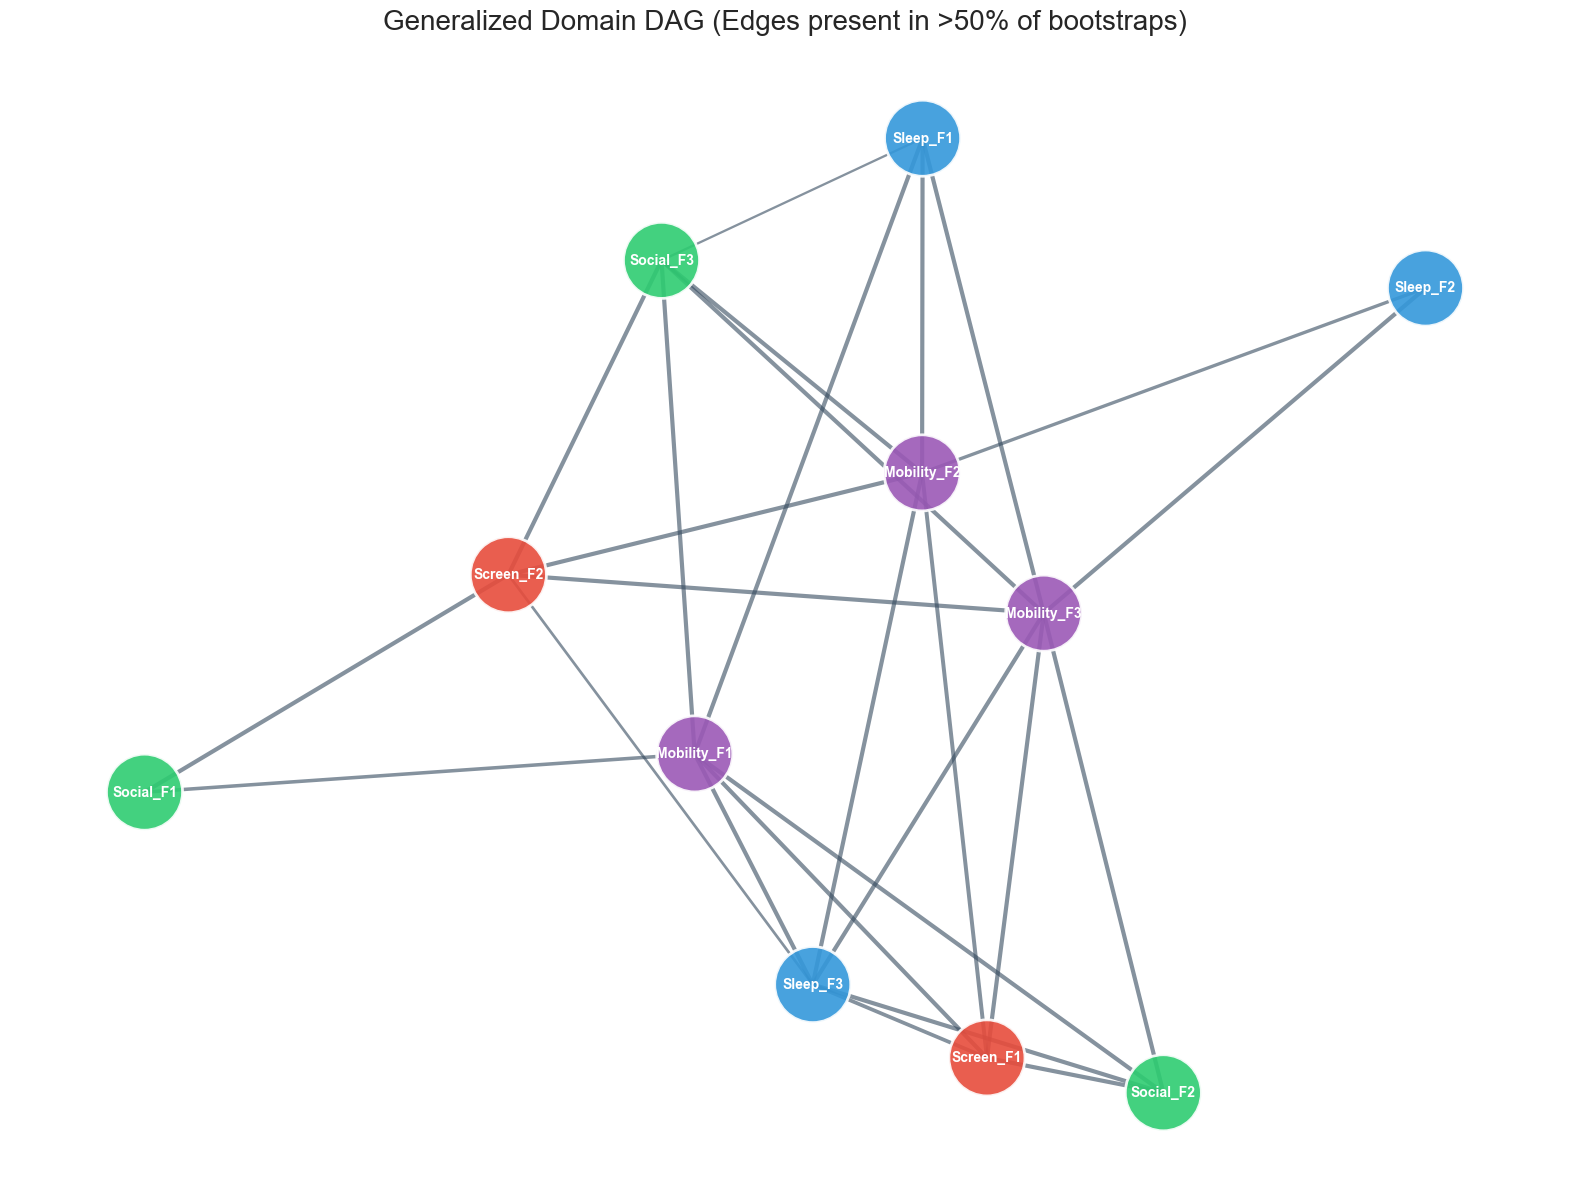

In [48]:
def get_domain_color(node_name):
    if 'Sleep' in node_name: return '#3498db'  # Blue
    if 'Social' in node_name: return '#2ecc71' # Green
    if 'Screen' in node_name: return '#e74c3c' # Red
    if 'Mobility' in node_name: return '#9b59b6' # Purple
    return '#95a5a6'

def plot_consensus_dag(edge_counts, all_labels, threshold=0.5, n_boots=20):
    G = nx.Graph()
    G.add_nodes_from(all_labels)
    
    min_count = threshold * n_boots
    for (u, v), count in edge_counts.items():
        if count >= min_count:
            stability = count / n_boots
            G.add_edge(u, v, weight=stability, penwidth=stability*3)
            
    plt.figure(figsize=(20, 15))
    pos = nx.spring_layout(G, k=0.5, seed=42, iterations=50)
    
    node_colors = [get_domain_color(n) for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color=node_colors, alpha=0.9, edgecolors='white', linewidths=2)
    edge_weights = [G[u][v]['weight']*3 for u,v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color='#34495e', alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', font_color='white')
    
    plt.title(f"Generalized Domain DAG (Edges present in >{threshold*100:.0f}% of bootstraps)", fontsize=20)
    plt.axis('off')
    plt.show()
    return G

final_graph = plot_consensus_dag(edge_stability, labels, threshold=0.5)

In [49]:
# Save Final Results
df_generalized.to_csv(os.path.join(DATA_DIR, 'latent_constructs.csv'))
adj_matrix = nx.to_numpy_array(final_graph, nodelist=labels)
np.savetxt(os.path.join(DATA_DIR, 'final_domain_dag.csv'), adj_matrix, delimiter=',')
print("Rules of Life saved. Notebook Complete.")

Rules of Life saved. Notebook Complete.
